<a href="https://colab.research.google.com/github/tianbingsz/LLM/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 11: Vision Transformers

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2023-10-11T16:46:16.362239

[Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied a Transformer on a variety of image recognition benchmarks.
We are implementing a Vision Transformer ourselves, and train it on the popular, small dataset CIFAR10.

## Setup
This notebook requires some packages besides pytorch-lightning.

In [ ]:
! pip install --quiet "ipython[notebook]>=8.0.0, <8.17.0" "setuptools>=68.0.0, <68.3.0" "tensorboard" "lightning>=2.0.0" "urllib3" "torch>=1.8.1, <2.1.0" "matplotlib" "pytorch-lightning>=1.4, <2.1.0" "seaborn" "torchvision" "torchmetrics>=0.7, <1.3" "matplotlib>=3.0.0, <3.9.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.0/807.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 403.3/619.9 MB 32.7 MB/s eta 0:00:07

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/4UyBxlJChfc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>
Let's start with importing our standard set of libraries.

In [ ]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

We provide a pre-trained Vision Transformer which we download in the next cell.
However, Vision Transformers can be relatively quickly trained on CIFAR10 with an overall training time of less than an hour on an NVIDIA TitanRTX.
Feel free to experiment with training your own Transformer once you went through the whole notebook.

In [ ]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = [
    "tutorial15/ViT.ckpt",
    "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/", 1)[1])
    if "/" in file_name.split("/", 1)[1]:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

We load the CIFAR10 dataset below.
We use the same setup of the datasets and data augmentations as for the CNNs in Tutorial 5 to keep a fair comparison.
The constants in the `transforms.Normalize` correspond to the values
that scale and shift the data to a zero mean and standard deviation of
one.

  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 98304/170498071 [00:00<03:43, 763182.28it/s]

  1%|          | 884736/170498071 [00:00<00:37, 4486525.61it/s]

  2%|▏         | 3211264/170498071 [00:00<00:13, 12498867.06it/s]

  5%|▍         | 7733248/170498071 [00:00<00:06, 24900795.19it/s]

  7%|▋         | 12615680/170498071 [00:00<00:04, 33241503.66it/s]

 10%|▉         | 17006592/170498071 [00:00<00:04, 36781615.61it/s]

 13%|█▎        | 21594112/170498071 [00:00<00:03, 39689233.53it/s]

 15%|█▌        | 26279936/170498071 [00:00<00:03, 41874715.49it/s]

 18%|█▊        | 31227904/170498071 [00:00<00:03, 44218287.55it/s]

 21%|██        | 36110336/170498071 [00:01<00:02, 45553287.96it/s]

 24%|██▍       | 41058304/170498071 [00:01<00:02, 46673015.04it/s]

 27%|██▋       | 46006272/170498071 [00:01<00:02, 47487844.08it/s]

 30%|██▉       | 50855936/170498071 [00:01<00:02, 47692996.39it/s]

 33%|███▎      | 55803904/170498071 [00:01<00:02, 48207485.48it/s]

 36%|███▌      | 60653568/170498071 [00:01<00:02, 48255353.54it/s]

 38%|███▊      | 65568768/170498071 [00:01<00:02, 48497919.86it/s]

 41%|████▏     | 70483968/170498071 [00:01<00:02, 48603041.49it/s]

 44%|████▍     | 75431936/170498071 [00:01<00:01, 48780540.50it/s]

 47%|████▋     | 80412672/170498071 [00:01<00:01, 49008259.91it/s]

 50%|█████     | 85327872/170498071 [00:02<00:01, 48891124.81it/s]

 53%|█████▎    | 90243072/170498071 [00:02<00:01, 48902059.32it/s]

 56%|█████▌    | 95158272/170498071 [00:02<00:01, 48124115.55it/s]

 59%|█████▊    | 100106240/170498071 [00:02<00:01, 48452421.40it/s]

 62%|██████▏   | 104955904/170498071 [00:02<00:01, 48423540.47it/s]

 64%|██████▍   | 109903872/170498071 [00:02<00:01, 48704278.85it/s]

 67%|██████▋   | 114819072/170498071 [00:02<00:01, 48734394.47it/s]

 70%|███████   | 119734272/170498071 [00:02<00:01, 48857814.53it/s]

 73%|███████▎  | 124649472/170498071 [00:02<00:00, 48917312.13it/s]

 76%|███████▌  | 129564672/170498071 [00:02<00:00, 48758175.20it/s]

 79%|███████▉  | 134512640/170498071 [00:03<00:00, 48893921.50it/s]

 82%|████████▏ | 139427840/170498071 [00:03<00:00, 48825870.10it/s]

 85%|████████▍ | 144375808/170498071 [00:03<00:00, 48944962.19it/s]

 88%|████████▊ | 149291008/170498071 [00:03<00:00, 48778397.38it/s]

 90%|█████████ | 154238976/170498071 [00:03<00:00, 48960514.84it/s]

 93%|█████████▎| 159154176/170498071 [00:03<00:00, 48864201.93it/s]

 96%|█████████▌| 164069376/170498071 [00:03<00:00, 48886923.35it/s]

 99%|█████████▉| 168984576/170498071 [00:03<00:00, 48906058.69it/s]

100%|██████████| 170498071/170498071 [00:03<00:00, 45061415.35it/s]

Extracting /__w/13/s/.datasets/cifar-10-python.tar.gz to /__w/13/s/.datasets


Files already downloaded and verified


Global seed set to 42


Global seed set to 42


Files already downloaded and verified


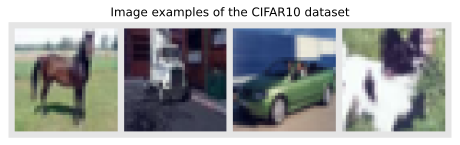

In [ ]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Transformers for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted.
To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it.
So, why not do the same thing on images?
This is exactly what [Alexey Dosovitskiy et al. ](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale".
Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches.
As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches.
Each of those patches is considered to be a "word"/"token", and projected to a feature space.
With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task.
A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/vit_architecture.png" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves.
First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$.
These represent the input words to the Transformer.

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

Let's take a look at how that works for our CIFAR examples above.
For our images of size $32\times 32$, we choose a patch size of 4.
Hence, we obtain sequences of 64 patches of size $4\times 4$.
We visualize them below:

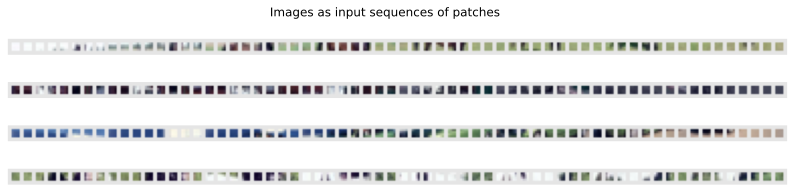

In [ ]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now.
Still, this is the input we provide to the Transformer for classifying the images.
The model has to learn itself how it has to combine the patches to recognize the objects.
The inductive bias in CNNs that an image is grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model.
Since we have discussed the fundamentals of Multi-Head Attention in [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html), we will use the PyTorch module `nn.MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)) here.
Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al. ](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020.
The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks.
This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage.
A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/11-vision-transformer/pre_layer_norm.svg" width="400px"></center>

The implementation of the Pre-LN attention block looks as follows:

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

Now we have all modules ready to build our own Vision Transformer.
Besides the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size.
It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence.
We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer.
Those are needed to learn position-dependent information, and convert the set to a sequence.
Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* A **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction.
This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let's implement the full Vision Transformer below:

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

Finally, we can put everything into a PyTorch Lightning Module as usual.
We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation.
Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore.
Instead, we use the same learning rate scheduler as the CNNs in our previous tutorial on image classification.

In [ ]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

## Experiments

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential.
However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10?
To find this out, we train a Vision Transformer from scratch on the CIFAR10 dataset.
Let's first create a training function for our PyTorch Lightning module
which also loads the pre-trained model if you have downloaded it above.

In [34]:
def train_model(**kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        devices=1,
        max_epochs=50,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    #if os.path.isfile(pretrained_filename):
    #    print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
    #    model = ViT.load_from_checkpoint(pretrained_filename)
    #else:
    L.seed_everything(42)  # To be reproducible
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    # Load best checkpoint after training
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Now, we can already start training our model.
As seen in our implementation, we have couple of hyperparameter that we have to choose.
When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below.
Nevertheless, it is worth to discuss the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size.
The smaller we make the patches, the longer the input sequences to the Transformer become.
While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer.
Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away.
We experimented with patch sizes of 2, 4 and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively.
We found 4 to result in the best performance, and hence pick it below.

Next, the embedding and hidden dimensionality have a similar impact to a Transformer as to an MLP.
The larger the sizes, the more complex the model becomes, and the longer it takes to train.
In Transformer however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers.
Each key has the feature dimensionality of `embed_dim/num_heads`.
Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32.
Lower dimensionalities can restrain the possible attention maps too much.
We observed that more than 8 heads are not necessary for the Transformer, and therefore pick a embedding dimensionality of `256`.
The hidden dimensionality in the feed-forward networks is usually 2-4x larger than the embedding dimensionality, and thus we pick `512`.

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5.
However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems.
To reduce overfitting, we use a dropout value of 0.2.
Remember that we also use small image augmentations as regularization during training.

Feel free to explore the hyperparameters yourself by changing the values below.
In general, the Vision Transformer did not show to be too sensitive to
the hyperparameter choices on the CIFAR10 dataset.

In [35]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 4,
        "num_channels": 3,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("ViT results", results)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params | In sizes         | Out sizes
---------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [128, 3, 32, 32] | [128, 10]
-------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.7335999608039856, 'val': 0.7414000034332275}


## Conclusion

In this tutorial, we have implemented our own Vision Transformer from scratch and applied it on the task of image classification.
Vision Transformers work by splitting an image into a sequence of smaller patches, use those as input to a standard Transformer encoder.
While Vision Transformers achieved outstanding results on large-scale image recognition benchmarks such as ImageNet, they considerably underperform when being trained from scratch on small-scale datasets like CIFAR10.
The reason is that in contrast to CNNs, Transformers do not have the inductive biases of translation invariance and the feature hierarchy (i.e. larger patterns consist of many smaller patterns).
However, these aspects can be learned when enough data is provided, or the model has been pre-trained on other large-scale tasks.
Considering that Vision Transformers have just been proposed end of 2020, there is likely a lot more to come on Transformers for Computer Vision.


### References

Dosovitskiy, Alexey, et al.
"An image is worth 16x16 words: Transformers for image recognition at scale."
International Conference on Representation Learning (2021).
[link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al.
"When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations."
arXiv preprint arXiv:2106.01548 (2021).
[link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al.
"MLP-mixer: An all-MLP Architecture for Vision."
arXiv preprint arXiv:2105.01601 (2021).
[link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al.
"On layer normalization in the transformer architecture."
International Conference on Machine Learning.
PMLR, 2020.
[link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)